# Data Cleaning

This notebook explores our "messy" data, the list of 11,000+ citations that had no DOI associated with them.

In [2]:
import csv
import pandas as pd
from time import sleep
from datetime import datetime as dt
import re
import os
import json
import requests
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates

## Import file
Read in the file of "messy" data, "no_doi.csv"

In [3]:
nodoi = pd.read_csv("no_doi.csv", encoding="ISO-8859-1")
nodoi

,ï»¿Author,Year,Title
0,___,2001,______
1,___,2007,[Journal of Korean Society on Water Environment
2,___,2007,[Journal of Korean Society on Water Environment
3,??,2012,Scientia Sinica Terrae]
4,???,1997,??
...,...,...,...
11276,NaN,2008,HYDRANAUTICS CHEM PR
11277,NaN,2005,MULLITE
11278,NaN,2005,NEURAL NETWORK
11279,NaN,2010,ZOOKEYS


## Count
Group by count to get a sense of the frequency of titles represented.

In [4]:
summary = nodoi['Title'].value_counts().rename_axis('journal_book').reset_index(name='counts')
summary.head(20)

,journal_book,counts
0,[No title captured],338
1,THESIS,160
2,Bulletin of the Seismological Society of America,126
3,Bulletin of the American Meteorological Society,68
4,American Mineralogist,62
5,Journal of Geophysical Research,51
6,AAPG Bulletin,49
7,J CLIMATE,47
8,Q J ROY METEOR SOC,43
9,CLIMATE CHANGE 2007: THE PHYSICAL SCIENCE BASIS,41


In the top 20, we see variations on "Thesis," "Climate Change 2007" and "Climate Change 2013." The last two are heavily cited IPCC reports. The top result is "No title captured" with 338 instances. Rather than clean up all 11,280, we might focus our clean up on these records. If we look back at our original results, it is likely that the addition of the remaining titles will not impact our results, but let's take a look.

# Calculating 80/20 rule for "no DOI" data
The records without DOIs represented about 20% of our total records (11,280/55,580). Let's take a closer look at this 20% to see how it differs from the rest of the results. 

The following 6 cells will help us calculate and graph the 80/20 rule for these records.

In [5]:
summary['cumsum'] = summary['counts'].cumsum()
summary

,journal_book,counts,cumsum
0,[No title captured],338,338
1,THESIS,160,498
2,Bulletin of the Seismological Society of America,126,624
3,Bulletin of the American Meteorological Society,68,692
4,American Mineralogist,62,754
...,...,...,...
7175,EXTRAIT COURS ZOOLOG,1,11176
7176,P 9 ANN C CARB CAPT,1,11177
7177,INTERPRETATION THEOR,1,11178
7178,HIGH RESOLUTION MAPP,1,11179


In [6]:
summary['titlenum'] = range(1, 1+len(summary))
summary

,journal_book,counts,cumsum,titlenum
0,[No title captured],338,338,1
1,THESIS,160,498,2
2,Bulletin of the Seismological Society of America,126,624,3
3,Bulletin of the American Meteorological Society,68,692,4
4,American Mineralogist,62,754,5
...,...,...,...,...
7175,EXTRAIT COURS ZOOLOG,1,11176,7176
7176,P 9 ANN C CARB CAPT,1,11177,7177
7177,INTERPRETATION THEOR,1,11178,7178
7178,HIGH RESOLUTION MAPP,1,11179,7179


In [7]:
summary['titlepct'] = 100*(summary.titlenum/7180)
summary

,journal_book,counts,cumsum,titlenum,titlepct
0,[No title captured],338,338,1,0.013928
1,THESIS,160,498,2,0.027855
2,Bulletin of the Seismological Society of America,126,624,3,0.041783
3,Bulletin of the American Meteorological Society,68,692,4,0.055710
4,American Mineralogist,62,754,5,0.069638
...,...,...,...,...,...
7175,EXTRAIT COURS ZOOLOG,1,11176,7176,99.944290
7176,P 9 ANN C CARB CAPT,1,11177,7177,99.958217
7177,INTERPRETATION THEOR,1,11178,7178,99.972145
7178,HIGH RESOLUTION MAPP,1,11179,7179,99.986072


In [8]:
summary['citationpct'] = 100*summary['cumsum']/(11180)
summary

,journal_book,counts,cumsum,titlenum,titlepct,citationpct
0,[No title captured],338,338,1,0.013928,3.023256
1,THESIS,160,498,2,0.027855,4.454383
2,Bulletin of the Seismological Society of America,126,624,3,0.041783,5.581395
3,Bulletin of the American Meteorological Society,68,692,4,0.055710,6.189624
4,American Mineralogist,62,754,5,0.069638,6.744186
...,...,...,...,...,...,...
7175,EXTRAIT COURS ZOOLOG,1,11176,7176,99.944290,99.964222
7176,P 9 ANN C CARB CAPT,1,11177,7177,99.958217,99.973166
7177,INTERPRETATION THEOR,1,11178,7178,99.972145,99.982111
7178,HIGH RESOLUTION MAPP,1,11179,7179,99.986072,99.991055


In [9]:
ind=np.argmin(abs(80.-summary.citationpct))
pctile = summary.titlepct[ind]
pctile

68.85793871866295

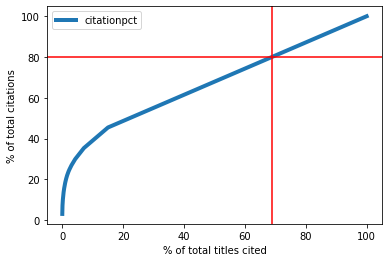

In [10]:
newlines = summary.plot.line(x='titlepct', y='citationpct', linewidth=4)
newlines.axhline(y=80, color='r')
newlines.axvline(x=pctile, color='r')
newlines.set_ylabel('% of total citations')
newlines.set_xlabel('% of total titles cited')
plt.show()

Wow, that's an interesting result! It suggests that the "long tail" of citations is varied and each title is only cited once. If we add these records back into the full set, how will the results change? 

# Clean up and compare

Limited clean up was done on the no_doi.csv file as follows:
1. Split “CR” column by comma - dates were fairly clean. 
2. Sort titles and group by frequency. 
3. Titles appearing 20 or more times were cleaned to match the original data set.

Examples: 
All versions of USGS edited to “USGS”
All versions of Thesis → “Thesis”
Abbreviated titles like Am. Min. were changed to the full title: American Mineralogist

The no_doi.csv records were then added back to the full data set (55,580) which we will import below as "citedRefsMeta_2".

In [11]:
data = pd.read_csv("citedRefsMeta_2.csv", encoding="ISO-8859-1")
data

,ï»¿Inst,citingDOI,CR,citedDOI,title,journal_book,date,issn1,issn1Type,issn2,issn2Type,isbn
0,Berkeley,NaN,"GAULTIERI N., 1742, INDEX TESTARUM CONCH",NaN,NaN,INDEX TESTARUM CONCH,1742.0,NaN,NaN,NaN,NaN,NaN
1,Berkeley,NaN,"PLANCUS J., 1743, EPISTOLA CONCHIS MEM, Vi, P195",NaN,NaN,EPISTOLA CONCHIS MEM,1743.0,NaN,NaN,NaN,NaN,NaN
2,Berkeley,NaN,"LINNAEUS C. VON, 1758, SYSTEMA NATURAE SIVE, V1",NaN,NaN,SYSTEMA NATURAE SIVE,1758.0,NaN,NaN,NaN,NaN,NaN
3,Berkeley,10.1080/02724634.2017.1306536,"Brisson A. D., 1762, REGNUMANIMALE CLASSE",NaN,NaN,REGNUMANIMALE CLASSE,1762.0,NaN,NaN,NaN,NaN,NaN
4,Berkeley,NaN,"Soldani A., 1789, TESTACEOGRAHIAE AC Z",NaN,NaN,TESTACEOGRAHIAE AC Z,1789.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
55575,Berkeley,10.3390/w10030244,"World Health Organization, GUID DRINK WAT QUAL",NaN,NaN,GUID DRINK WAT QUAL,NaN,NaN,NaN,NaN,NaN,NaN
55576,UCLA,10.6038/j.issn.0001-5733.2012.12.003,"Xue A M, CPS SEG BEIJING 2009",NaN,NaN,CPS SEG BEIJING 2009,NaN,NaN,NaN,NaN,NaN,NaN
55577,UCLA,10.6038/j.issn.0001-5733.2012.12.003,"Zhang P Z, GEOLOGICAL SOC AM B, V102, P1484",NaN,NaN,Geological Society of America Bulletin,NaN,NaN,NaN,NaN,NaN,NaN
55578,Berkeley,10.1016/j.isprsjprs.2014.03.007,"Zhao Y., INT J REMOTE S UNPUB",NaN,NaN,INT J REMOTE S UNPUB,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
#Clean up column name
data = data.rename(columns={"ï»¿Inst": "Inst"})
data

,Inst,citingDOI,CR,citedDOI,title,journal_book,date,issn1,issn1Type,issn2,issn2Type,isbn
0,Berkeley,NaN,"GAULTIERI N., 1742, INDEX TESTARUM CONCH",NaN,NaN,INDEX TESTARUM CONCH,1742.0,NaN,NaN,NaN,NaN,NaN
1,Berkeley,NaN,"PLANCUS J., 1743, EPISTOLA CONCHIS MEM, Vi, P195",NaN,NaN,EPISTOLA CONCHIS MEM,1743.0,NaN,NaN,NaN,NaN,NaN
2,Berkeley,NaN,"LINNAEUS C. VON, 1758, SYSTEMA NATURAE SIVE, V1",NaN,NaN,SYSTEMA NATURAE SIVE,1758.0,NaN,NaN,NaN,NaN,NaN
3,Berkeley,10.1080/02724634.2017.1306536,"Brisson A. D., 1762, REGNUMANIMALE CLASSE",NaN,NaN,REGNUMANIMALE CLASSE,1762.0,NaN,NaN,NaN,NaN,NaN
4,Berkeley,NaN,"Soldani A., 1789, TESTACEOGRAHIAE AC Z",NaN,NaN,TESTACEOGRAHIAE AC Z,1789.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
55575,Berkeley,10.3390/w10030244,"World Health Organization, GUID DRINK WAT QUAL",NaN,NaN,GUID DRINK WAT QUAL,NaN,NaN,NaN,NaN,NaN,NaN
55576,UCLA,10.6038/j.issn.0001-5733.2012.12.003,"Xue A M, CPS SEG BEIJING 2009",NaN,NaN,CPS SEG BEIJING 2009,NaN,NaN,NaN,NaN,NaN,NaN
55577,UCLA,10.6038/j.issn.0001-5733.2012.12.003,"Zhang P Z, GEOLOGICAL SOC AM B, V102, P1484",NaN,NaN,Geological Society of America Bulletin,NaN,NaN,NaN,NaN,NaN,NaN
55578,Berkeley,10.1016/j.isprsjprs.2014.03.007,"Zhao Y., INT J REMOTE S UNPUB",NaN,NaN,INT J REMOTE S UNPUB,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
#Let's call this "cleandata" and look at the title counts again.
cleandata = data['journal_book'].value_counts().rename_axis('journal_book').reset_index(name='counts')
cleandata

,journal_book,counts
0,Journal of Geophysical Research,2562
1,Geophysical Research Letters,2478
2,Atmospheric Chemistry and Physics,1341
3,Journal of Climate,1288
4,Science,1225
...,...,...
9666,Environmental Geology and Water Sciences,1
9667,REMOTE SENS LETT,1
9668,GPS SOLUTIONS,1
9669,HYDRO17 NWS,1


In [14]:
#Here's how you check the place of a single title

title_check = cleandata.loc[cleandata['journal_book'] == 'Climate Research']
title_check

,journal_book,counts
272,Climate Research,22


In [15]:
#Run the next cells to reconstruct the 80/20 rule

cleandata['cumsum'] = cleandata['counts'].cumsum()
cleandata

,journal_book,counts,cumsum
0,Journal of Geophysical Research,2562,2562
1,Geophysical Research Letters,2478,5040
2,Atmospheric Chemistry and Physics,1341,6381
3,Journal of Climate,1288,7669
4,Science,1225,8894
...,...,...,...
9666,Environmental Geology and Water Sciences,1,55559
9667,REMOTE SENS LETT,1,55560
9668,GPS SOLUTIONS,1,55561
9669,HYDRO17 NWS,1,55562


In [16]:
cleandata['titlenum'] = range(1, 1+len(cleandata))
cleandata

,journal_book,counts,cumsum,titlenum
0,Journal of Geophysical Research,2562,2562,1
1,Geophysical Research Letters,2478,5040,2
2,Atmospheric Chemistry and Physics,1341,6381,3
3,Journal of Climate,1288,7669,4
4,Science,1225,8894,5
...,...,...,...,...
9666,Environmental Geology and Water Sciences,1,55559,9667
9667,REMOTE SENS LETT,1,55560,9668
9668,GPS SOLUTIONS,1,55561,9669
9669,HYDRO17 NWS,1,55562,9670


In [17]:
cleandata['titlepct'] = 100*(cleandata.titlenum/9671)
cleandata

,journal_book,counts,cumsum,titlenum,titlepct
0,Journal of Geophysical Research,2562,2562,1,0.010340
1,Geophysical Research Letters,2478,5040,2,0.020680
2,Atmospheric Chemistry and Physics,1341,6381,3,0.031021
3,Journal of Climate,1288,7669,4,0.041361
4,Science,1225,8894,5,0.051701
...,...,...,...,...,...
9666,Environmental Geology and Water Sciences,1,55559,9667,99.958639
9667,REMOTE SENS LETT,1,55560,9668,99.968979
9668,GPS SOLUTIONS,1,55561,9669,99.979320
9669,HYDRO17 NWS,1,55562,9670,99.989660


In [18]:
cleandata['citationpct'] = 100*cleandata['cumsum']/(55563)
cleandata

,journal_book,counts,cumsum,titlenum,titlepct,citationpct
0,Journal of Geophysical Research,2562,2562,1,0.010340,4.610982
1,Geophysical Research Letters,2478,5040,2,0.020680,9.070785
2,Atmospheric Chemistry and Physics,1341,6381,3,0.031021,11.484261
3,Journal of Climate,1288,7669,4,0.041361,13.802350
4,Science,1225,8894,5,0.051701,16.007055
...,...,...,...,...,...,...
9666,Environmental Geology and Water Sciences,1,55559,9667,99.958639,99.992801
9667,REMOTE SENS LETT,1,55560,9668,99.968979,99.994601
9668,GPS SOLUTIONS,1,55561,9669,99.979320,99.996400
9669,HYDRO17 NWS,1,55562,9670,99.989660,99.998200


# Calculate 80/20 rule
We can recalculate the 80/20 rule below with the clean data, we're back under 10%, meaning 80% of citations come from 9.33% of titles. This is a slight shift from our first analysis which placed 80% of citations coming from 7.88% of titles.

In [19]:
ind=np.argmin(abs(80.-cleandata.citationpct))
pctile = cleandata.titlepct[ind]
pctile

9.337193671802295

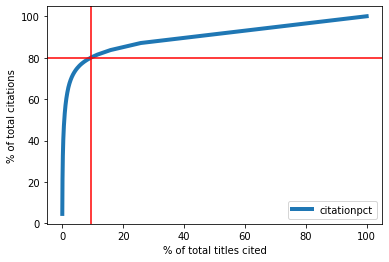

In [20]:
newlines = cleandata.plot.line(x='titlepct', y='citationpct', linewidth=4)
newlines.axhline(y=80, color='r')
newlines.axvline(x=pctile, color='r')
newlines.set_ylabel('% of total citations')
newlines.set_xlabel('% of total titles cited')
plt.show()

## Compare "messy" vs. "clean" data
We can also compare with our original results to the rank of particular titles have changed.

In [21]:
#This is the original file.

citedRefsMeta = pd.read_csv('citedRefsMeta.csv', encoding='utf-8')

In [22]:
citedRefsMeta_count = citedRefsMeta['journal_book'].value_counts().rename_axis('journal_book').reset_index(name='counts')
citedRefsMeta_count

,journal_book,counts
0,Journal of Geophysical Research,2509
1,Geophysical Research Letters,2451
2,Atmospheric Chemistry and Physics,1310
3,Journal of Climate,1241
4,Science,1225
...,...,...
2710,Acta Crystallographica Section B Structural Cr...,1
2711,Thorax,1
2712,Construction Management and Economics,1
2713,QJM,1


Let's compare the top titles before and after data cleaning. What, if anything, has changed?
The left column shows the early data, the right column, the clean data after names were edited and regularized.

In [23]:
compare = pd.concat([citedRefsMeta_count['journal_book'], cleandata['journal_book']], axis=1, keys=['before', 'after'])

In [24]:
compare.head(20)

,before,after
0,Journal of Geophysical Research,Journal of Geophysical Research
1,Geophysical Research Letters,Geophysical Research Letters
2,Atmospheric Chemistry and Physics,Atmospheric Chemistry and Physics
3,Journal of Climate,Journal of Climate
4,Science,Science
5,Nature,Nature
6,Journal of Geophysical Research: Atmospheres,Journal of Geophysical Research: Atmospheres
7,Earth and Planetary Science Letters,Earth and Planetary Science Letters
8,Journal of Geophysical Research: Space Physics,Journal of Geophysical Research: Space Physics
9,Journal of the Atmospheric Sciences,Journal of the Atmospheric Sciences


The top titles were cited over 1,000 times. Even with cleaning and grouping variants of a title, it does not impact the most cited list very much. 

For example, let's look at the Seismological Society of America in the next two cells. In the messy data, the journal appeared 168 times. Once the variations and abbreviations of the title were cleaned, it appeared 294 times. That's a big jump, but the title was still within the top 50 before and after.

In [25]:
#Example: Seismological Society of America before variations of title were cleaned.

SSA_before = citedRefsMeta_count.loc[citedRefsMeta_count['journal_book'] == 'Bulletin of the Seismological Society of America']
SSA_before

,journal_book,counts
44,Bulletin of the Seismological Society of America,168


In [26]:
#Example: Seismological Society of America after variations of title were cleaned.

SSA_after = cleandata.loc[cleandata['journal_book'] == 'Bulletin of the Seismological Society of America']
SSA_after

,journal_book,counts,cumsum,titlenum,titlepct,citationpct
29,Bulletin of the Seismological Society of America,294,21794,30,0.310206,39.223944


## Analysis by institution
While the 80/20 rule is useful for core collecting, the long tail of works that are cited only once or twice are still important. These works make library collections unique and aid in answering specific research questions. When we add the messier data back, the long tail of works that are cited once, how does it impact an institution's adherence to the 80/20 rule?

### Berkeley

In [27]:
citedRefsMeta_ucb = data.loc[data['Inst'] == 'Berkeley']
citedRefsMeta_ucb_count = citedRefsMeta_ucb['journal_book'].value_counts().rename_axis('journal_book').reset_index(name='counts')
citedRefsMeta_ucb_count['cumsum'] = citedRefsMeta_ucb_count['counts'].cumsum()
citedRefsMeta_ucb_count['titlenum'] = range(1, 1+len(citedRefsMeta_ucb_count))
citedRefsMeta_ucb_count['titlenum']

0          1
1          2
2          3
3          4
4          5
        ... 
4317    4318
4318    4319
4319    4320
4320    4321
4321    4322
Name: titlenum, Length: 4322, dtype: int64

In [28]:
citedRefsMeta_ucb_count['titlepct'] = 100*(citedRefsMeta_ucb_count.titlenum/4322)
citedRefsMeta_ucb_count

,journal_book,counts,cumsum,titlenum,titlepct
0,Journal of Geophysical Research,558,558,1,0.023137
1,Geophysical Research Letters,477,1035,2,0.046275
2,Earth and Planetary Science Letters,339,1374,3,0.069412
3,Science,324,1698,4,0.092550
4,Nature,321,2019,5,0.115687
...,...,...,...,...,...
4317,Process Biochemistry,1,16843,4318,99.907450
4318,HOLE FILLED SRTM GLO,1,16844,4319,99.930588
4319,WOODHEAD PUBL SER EN,1,16845,4320,99.953725
4320,46 LUN PLAN SCI C CD,1,16846,4321,99.976863


In [29]:
citedRefsMeta_ucb_count['citationpct'] = 100*citedRefsMeta_ucb_count['cumsum']/(16847)
citedRefsMeta_ucb_count

,journal_book,counts,cumsum,titlenum,titlepct,citationpct
0,Journal of Geophysical Research,558,558,1,0.023137,3.312162
1,Geophysical Research Letters,477,1035,2,0.046275,6.143527
2,Earth and Planetary Science Letters,339,1374,3,0.069412,8.155755
3,Science,324,1698,4,0.092550,10.078946
4,Nature,321,2019,5,0.115687,11.984330
...,...,...,...,...,...,...
4317,Process Biochemistry,1,16843,4318,99.907450,99.976257
4318,HOLE FILLED SRTM GLO,1,16844,4319,99.930588,99.982193
4319,WOODHEAD PUBL SER EN,1,16845,4320,99.953725,99.988128
4320,46 LUN PLAN SCI C CD,1,16846,4321,99.976863,99.994064


In [30]:
ind=np.argmin(abs(80.-citedRefsMeta_ucb_count.citationpct))
pctile_ucb = citedRefsMeta_ucb_count.titlepct[ind]
pctile_ucb

24.317445627024526

### Boulder

In [31]:
citedRefsMeta_cub = data.loc[data['Inst'] == 'CUBoulder']
citedRefsMeta_cub_count = citedRefsMeta_cub['journal_book'].value_counts().rename_axis('journal_book').reset_index(name='counts')
citedRefsMeta_cub_count['cumsum'] = citedRefsMeta_cub_count['counts'].cumsum()
citedRefsMeta_cub_count['titlenum'] = range(1, 1+len(citedRefsMeta_cub_count))
citedRefsMeta_cub_count['titlenum']

0          1
1          2
2          3
3          4
4          5
        ... 
4226    4227
4227    4228
4228    4229
4229    4230
4230    4231
Name: titlenum, Length: 4231, dtype: int64

In [32]:
citedRefsMeta_cub_count['titlepct'] = 100*(citedRefsMeta_cub_count.titlenum/4231)
citedRefsMeta_cub_count

,journal_book,counts,cumsum,titlenum,titlepct
0,Journal of Geophysical Research,1434,1434,1,0.023635
1,Geophysical Research Letters,1401,2835,2,0.047270
2,Atmospheric Chemistry and Physics,939,3774,3,0.070905
3,Journal of Geophysical Research: Atmospheres,768,4542,4,0.094540
4,Journal of Climate,634,5176,5,0.118175
...,...,...,...,...,...
4226,GLOB SPAT DAT INF US,1,24031,4227,99.905460
4227,1 PEOPLES NEW WORLD,1,24032,4228,99.929095
4228,MOBIHOC 2006. Proceedings of the Seventh ACM I...,1,24033,4229,99.952730
4229,Advances in Climate Change Research,1,24034,4230,99.976365


In [33]:
citedRefsMeta_cub_count['citationpct'] = 100*citedRefsMeta_cub_count['cumsum']/(24035)
citedRefsMeta_cub_count

,journal_book,counts,cumsum,titlenum,titlepct,citationpct
0,Journal of Geophysical Research,1434,1434,1,0.023635,5.966299
1,Geophysical Research Letters,1401,2835,2,0.047270,11.795299
2,Atmospheric Chemistry and Physics,939,3774,3,0.070905,15.702101
3,Journal of Geophysical Research: Atmospheres,768,4542,4,0.094540,18.897441
4,Journal of Climate,634,5176,5,0.118175,21.535261
...,...,...,...,...,...,...
4226,GLOB SPAT DAT INF US,1,24031,4227,99.905460,99.983358
4227,1 PEOPLES NEW WORLD,1,24032,4228,99.929095,99.987518
4228,MOBIHOC 2006. Proceedings of the Seventh ACM I...,1,24033,4229,99.952730,99.991679
4229,Advances in Climate Change Research,1,24034,4230,99.976365,99.995839


In [34]:
ind=np.argmin(abs(80.-citedRefsMeta_cub_count.citationpct))
pctile_cub = citedRefsMeta_cub_count.titlepct[ind]
pctile_cub

9.714015599149137

### UCLA

In [35]:
citedRefsMeta_ucla = data.loc[data['Inst'] == 'UCLA']
citedRefsMeta_ucla_count = citedRefsMeta_ucla['journal_book'].value_counts().rename_axis('journal_book').reset_index(name='counts')
citedRefsMeta_ucla_count['cumsum'] = citedRefsMeta_ucla_count['counts'].cumsum()
citedRefsMeta_ucla_count['titlenum'] = range(1, 1+len(citedRefsMeta_ucla_count))
citedRefsMeta_ucla_count['titlenum']

0          1
1          2
2          3
3          4
4          5
        ... 
2926    2927
2927    2928
2928    2929
2929    2930
2930    2931
Name: titlenum, Length: 2931, dtype: int64

In [36]:
citedRefsMeta_ucla_count['titlepct'] = 100*(citedRefsMeta_ucla_count.titlenum/2931)
citedRefsMeta_ucla_count

,journal_book,counts,cumsum,titlenum,titlepct
0,Geophysical Research Letters,574,574,1,0.034118
1,Journal of Geophysical Research,530,1104,2,0.068236
2,Journal of Climate,520,1624,3,0.102354
3,Science,306,1930,4,0.136472
4,Journal of Geophysical Research: Space Physics,295,2225,5,0.170590
...,...,...,...,...,...
2926,REP IONOS SPACE RES,1,13075,2927,99.863528
2927,Interfaces,1,13076,2928,99.897646
2928,Application Research of Computers,1,13077,2929,99.931764
2929,CHEM IND-LONDON,1,13078,2930,99.965882


In [37]:
citedRefsMeta_ucla_count['citationpct'] = 100*citedRefsMeta_ucla_count['cumsum']/(13079)
citedRefsMeta_ucla_count

,journal_book,counts,cumsum,titlenum,titlepct,citationpct
0,Geophysical Research Letters,574,574,1,0.034118,4.388715
1,Journal of Geophysical Research,530,1104,2,0.068236,8.441012
2,Journal of Climate,520,1624,3,0.102354,12.416851
3,Science,306,1930,4,0.136472,14.756480
4,Journal of Geophysical Research: Space Physics,295,2225,5,0.170590,17.012004
...,...,...,...,...,...,...
2926,REP IONOS SPACE RES,1,13075,2927,99.863528,99.969417
2927,Interfaces,1,13076,2928,99.897646,99.977062
2928,Application Research of Computers,1,13077,2929,99.931764,99.984708
2929,CHEM IND-LONDON,1,13078,2930,99.965882,99.992354


In [38]:
ind=np.argmin(abs(80.-citedRefsMeta_ucla_count.citationpct))
pctile_ucla = citedRefsMeta_ucla_count.titlepct[ind]
pctile_ucla

19.379051518253156

### Houston

In [39]:
citedRefsMeta_uh = data.loc[data['Inst'] == 'Houston']
citedRefsMeta_uh_count = citedRefsMeta_uh['journal_book'].value_counts().rename_axis('journal_book').reset_index(name='counts')
citedRefsMeta_uh_count['cumsum'] = citedRefsMeta_uh_count['counts'].cumsum()
citedRefsMeta_uh_count['titlenum'] = range(1, 1+len(citedRefsMeta_uh_count))
citedRefsMeta_uh_count['titlenum']

0        1
1        2
2        3
3        4
4        5
      ... 
598    599
599    600
600    601
601    602
602    603
Name: titlenum, Length: 603, dtype: int64

In [40]:
citedRefsMeta_uh_count['titlepct'] = 100*(citedRefsMeta_uh_count.titlenum/603)
citedRefsMeta_uh_count

,journal_book,counts,cumsum,titlenum,titlepct
0,Geochimica et Cosmochimica Acta,71,71,1,0.165837
1,Earth and Planetary Science Letters,71,142,2,0.331675
2,GEOPHYSICS,45,187,3,0.497512
3,Meteoritics & Planetary Science,40,227,4,0.663350
4,Journal of Geophysical Research,40,267,5,0.829187
...,...,...,...,...,...
598,IEEE Transactions on Signal Processing,1,1598,599,99.336650
599,PETROLEUM GEOSCIENCE,1,1599,600,99.502488
600,POLAR SCI,1,1600,601,99.668325
601,INTRO FINITE ELEMENT,1,1601,602,99.834163


In [41]:
citedRefsMeta_uh_count['citationpct'] = 100*citedRefsMeta_uh_count['cumsum']/(1602)
citedRefsMeta_uh_count

,journal_book,counts,cumsum,titlenum,titlepct,citationpct
0,Geochimica et Cosmochimica Acta,71,71,1,0.165837,4.431960
1,Earth and Planetary Science Letters,71,142,2,0.331675,8.863920
2,GEOPHYSICS,45,187,3,0.497512,11.672909
3,Meteoritics & Planetary Science,40,227,4,0.663350,14.169788
4,Journal of Geophysical Research,40,267,5,0.829187,16.666667
...,...,...,...,...,...,...
598,IEEE Transactions on Signal Processing,1,1598,599,99.336650,99.750312
599,PETROLEUM GEOSCIENCE,1,1599,600,99.502488,99.812734
600,POLAR SCI,1,1600,601,99.668325,99.875156
601,INTRO FINITE ELEMENT,1,1601,602,99.834163,99.937578


In [42]:
ind=np.argmin(abs(80.-citedRefsMeta_uh_count.citationpct))
pctile_uh = citedRefsMeta_uh_count.titlepct[ind]
pctile_uh

46.93200663349917

These are the respective changes in the 80/20 rule aggregated and by institution before and after data cleaning:  
- Aggregate: 7.8% --> 9.3% 
- Boulder: 9.1% --> 9.7% 
- Berkeley: 16.9% --> 24.3% 
- UCLA: 14.9% --> 19.4% 
- Houston: 34.1% --> 46.9% 

The plot below visualizes these changes.

Text(0.5, 0, '% of total titles cited')

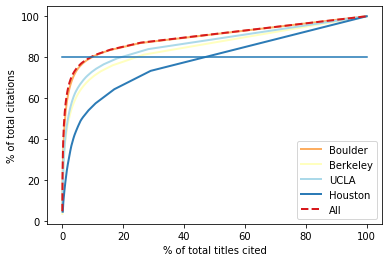

In [46]:

plt.plot('titlepct', 'citationpct', data=citedRefsMeta_cub_count, linewidth=2, color='#FDAE61', label = 'Boulder')
plt.plot('titlepct', 'citationpct', data=citedRefsMeta_ucb_count, linewidth=2, color='#ffffbf', label = 'Berkeley')
plt.plot('titlepct', 'citationpct', data=citedRefsMeta_ucla_count, linewidth=2, color='#abd9e9',  label = 'UCLA')
plt.plot('titlepct', 'citationpct', data=citedRefsMeta_uh_count, linewidth=2, color='#2c7bb6', label = 'Houston')
plt.plot('titlepct', 'citationpct', data=cleandata, linewidth=2, ls='--', color='#d7191c', label = 'All')

plt.legend()
x_coordinates = [0, 100]
y_coordinates = [80, 80]

plt.plot(x_coordinates, y_coordinates)

plt.ylabel('% of total citations')
plt.xlabel('% of total titles cited')

